In [ ]:
import pandas as pd
df =pd.read_csv("/content/drive/MyDrive/Colab Notebooks/metadata.csv")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.head(3)

,image_id,domain,split,image_path
0,n02381460_1000,B (Zebra),test,testB/n02381460_1000.jpg
1,n02381460_1001,A (Horse),train,trainA/n02381460_1001.jpg
2,n02381460_1002,A (Horse),train,trainA/n02381460_1002.jpg


In [ ]:
df['domain'].unique()

array(['B (Zebra)', 'A (Horse)'], dtype=object)

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import zipfile
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image

## train

In [ ]:
# CycleGAN 모델 정의
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolutional block
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
        ]

        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features
            out_features = in_features * 2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features
            out_features = in_features // 2

        # Output layer
        model += [nn.ReflectionPad2d(3), nn.Conv2d(64, output_nc, 7), nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        model = [
            nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
        ]

        model += [
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
        ]

        model += [
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        ]

        model += [
            nn.Conv2d(256, 512, 4, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        ]

        # FCN classification layer
        model += [nn.Conv2d(512, 1, 4, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        x = self.model(x)
        # Average pooling and flatten
        return nn.functional.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

# 학습 함수 수정
def train(generator_XY, generator_YX, discriminator_X, discriminator_Y,
          optimizer_G, optimizer_D, iterations, train_loader_X, train_loader_Y, sample_interval=200):
    adversarial_loss = torch.nn.MSELoss()

    len_data_loader_X = len(train_loader_X)
    len_data_loader_Y = len(train_loader_Y)

    for iteration in range(iterations):
        idx_X = iteration % len_data_loader_X
        idx_Y = iteration % len_data_loader_Y

        real_X, _ = next(iter(train_loader_X))
        real_Y, _ = next(iter(train_loader_Y))

        real_X = real_X.cuda()
        real_Y = real_Y.cuda()

        # Adversarial ground truths
        valid = torch.cuda.FloatTensor(real_X.size(0), 1).fill_(1.0)
        fake = torch.cuda.FloatTensor(real_X.size(0), 1).fill_(0.0)

        ###### Generator training ######
        optimizer_G.zero_grad()

        # Identity loss
        loss_id_X = adversarial_loss(generator_YX(real_X), real_X)
        loss_id_Y = adversarial_loss(generator_XY(real_Y), real_Y)

        # Adversarial loss
        fake_Y = generator_XY(real_X)
        loss_GAN_XY = adversarial_loss(discriminator_Y(fake_Y), valid)

        fake_X = generator_YX(real_Y)
        loss_GAN_YX = adversarial_loss(discriminator_X(fake_X), valid)

        # Cycle loss
        recovered_X = generator_YX(fake_Y)
        loss_cycle_X = torch.mean(torch.abs(recovered_X - real_X))

        recovered_Y = generator_XY(fake_X)
        loss_cycle_Y = torch.mean(torch.abs(recovered_Y - real_Y))

        # Total loss
        loss_G = (
            loss_id_X
            + loss_id_Y
            + loss_GAN_XY
            + loss_GAN_YX
            + loss_cycle_X * 10.0
            + loss_cycle_Y * 10.0
        )

        loss_G.backward()
        optimizer_G.step()

        ###### Discriminator training ######
        optimizer_D.zero_grad()

        # Discriminator losses
        loss_D_X = adversarial_loss(discriminator_X(real_X), valid) + adversarial_loss(discriminator_X(fake_X.detach()), fake)
        loss_D_Y = adversarial_loss(discriminator_Y(real_Y), valid) + adversarial_loss(discriminator_Y(fake_Y.detach()), fake)

        # Total loss
        loss_D = (loss_D_X + loss_D_Y) / 2

        loss_D.backward()
        optimizer_D.step()

        # Print losses
        if iteration % sample_interval == 0:
            print(
                "[Iteration %d/%d] [D loss: %f] [G loss: %f]"
                % (iteration, iterations, loss_D.item(), loss_G.item())
            )
            sample_images(generator_XY, generator_YX, real_X, real_Y, iteration)

# 샘플 이미지 생성 함수 수정
def sample_images(generator_XY, generator_YX, real_X, real_Y, iteration):

    # Generate fake images
    fake_Y = generator_XY(real_X)
    fake_X = generator_YX(real_Y)

    # Display images
    plt.figure(figsize=(10, 10))

    plt.subplot(2, 2, 1)
    plt.title("Real X")
    plt.imshow(real_X[0].permute(1, 2, 0).cpu().detach().numpy())

    plt.subplot(2, 2, 2)
    plt.title("Generated Y")
    plt.imshow(fake_Y[0].permute(1, 2, 0).cpu().detach().numpy())

    plt.subplot(2, 2, 3)
    plt.title("Real Y")
    plt.imshow(real_Y[0].permute(1, 2, 0).cpu().detach().numpy())

    plt.subplot(2, 2, 4)
    plt.title("Generated X")
    plt.imshow(fake_X[0].permute(1, 2, 0).cpu().detach().numpy())

    plt.savefig(f"images/CycleGAN_{iteration}.png")
    plt.close()

In [ ]:
# !unzip "/content/drive/MyDrive/Colab Notebooks/aisys/archive.zip" -d "/content/drive/MyDrive/Colab Notebooks/aisys"

In [ ]:
# 데이터 전처리 및 데이터 로더 설정
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_loader_X = DataLoader(
    datasets.ImageFolder("/content/drive/MyDrive/Colab Notebooks/aisys/A(horse)", transform=transform),
    batch_size=4,
    shuffle=True,
)

train_loader_Y = DataLoader(
    datasets.ImageFolder("/content/drive/MyDrive/Colab Notebooks/aisys/B(Zebra)", transform=transform),
    batch_size=4,
    shuffle=True,
)

In [ ]:
# 생성자 및 판별자 초기화
generator_XY = Generator(input_nc=3, output_nc=3).cuda()
generator_YX = Generator(input_nc=3, output_nc=3).cuda()
discriminator_X = Discriminator(input_nc=3).cuda()
discriminator_Y = Discriminator(input_nc=3).cuda()

# 손실 함수 및 최적화 기법 설정
optimizer_G = optim.Adam(
    list(generator_XY.parameters()) + list(generator_YX.parameters()), lr=0.0002, betas=(0.5, 0.999)
)
optimizer_D = optim.Adam(
    list(discriminator_X.parameters()) + list(discriminator_Y.parameters()), lr=0.0002, betas=(0.5, 0.999)
)

In [ ]:
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

In [ ]:
import os
image_dir = 'images'

if not os.path.exists(image_dir):
    os.makedirs(image_dir)

In [ ]:
# 학습 수행
iterations = 5000
train(
    generator_XY,
    generator_YX,
    discriminator_X,
    discriminator_Y,
    optimizer_G,
    optimizer_D,
    iterations,
    train_loader_X,
    train_loader_Y,
    sample_interval=200,
)

<ipython-input-6-69d3dfc30111>:124: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  valid = torch.cuda.FloatTensor(real_X.size(0), 1).fill_(1.0)


[Iteration 0/5000] [D loss: 0.727168] [G loss: 13.388146]


[Iteration 200/5000] [D loss: 0.642034] [G loss: 4.124189]


[Iteration 400/5000] [D loss: 0.750915] [G loss: 3.832580]


[Iteration 600/5000] [D loss: 0.263056] [G loss: 3.784913]


[Iteration 800/5000] [D loss: 0.339457] [G loss: 3.361545]


[Iteration 1000/5000] [D loss: 0.391951] [G loss: 3.536205]


[Iteration 1200/5000] [D loss: 0.369981] [G loss: 3.211404]


[Iteration 1400/5000] [D loss: 0.245661] [G loss: 3.429149]
[Iteration 1600/5000] [D loss: 0.418249] [G loss: 3.430816]


[Iteration 1800/5000] [D loss: 0.440174] [G loss: 3.055212]


[Iteration 2000/5000] [D loss: 0.341899] [G loss: 3.550218]


[Iteration 2200/5000] [D loss: 0.410820] [G loss: 3.268855]


[Iteration 2400/5000] [D loss: 0.422563] [G loss: 3.816343]


[Iteration 2600/5000] [D loss: 0.333219] [G loss: 3.095752]


[Iteration 2800/5000] [D loss: 0.346433] [G loss: 3.716205]


[Iteration 3000/5000] [D loss: 0.339706] [G loss: 3.416568]


[Iteration 3200/5000] [D loss: 0.339432] [G loss: 2.752524]
[Iteration 3400/5000] [D loss: 0.489176] [G loss: 3.397226]


[Iteration 3600/5000] [D loss: 0.445916] [G loss: 3.223884]


[Iteration 3800/5000] [D loss: 0.403257] [G loss: 2.949089]


[Iteration 4000/5000] [D loss: 0.316601] [G loss: 2.876317]


[Iteration 4200/5000] [D loss: 0.336162] [G loss: 3.290687]


[Iteration 4400/5000] [D loss: 0.259807] [G loss: 2.818895]


[Iteration 4600/5000] [D loss: 0.378073] [G loss: 2.961195]
[Iteration 4800/5000] [D loss: 0.294648] [G loss: 3.199159]


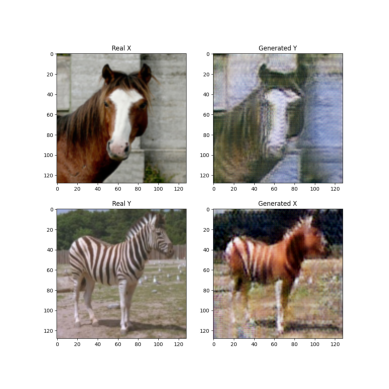

In [ ]:
from PIL import Image
image_path = '/content/images/CycleGAN_4200.png'

image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')

## test

In [ ]:
test_loader_X = DataLoader(
    datasets.ImageFolder("/content/drive/MyDrive/Colab Notebooks/test_horse", transform=transform),
    batch_size=1, shuffle=True)

test_loader_Y = DataLoader(
    datasets.ImageFolder("/content/drive/MyDrive/Colab Notebooks/test_zebra", transform=transform),
    batch_size=1,shuffle=True)

In [ ]:
from torchvision.utils import make_grid

def test(generator_XY, generator_YX, test_loader_X, test_loader_Y):
    generator_XY.eval()
    generator_YX.eval()

    real_X, _ = next(iter(test_loader_X))
    real_Y, _ = next(iter(test_loader_Y))

    real_X = real_X.cuda()
    real_Y = real_Y.cuda()

    with torch.no_grad():  #  gradient 계산 X
        fake_Y = generator_XY(real_X)
        fake_X = generator_YX(real_Y)

    plt.figure(figsize=(10, 10))

    plt.subplot(2, 2, 1)
    plt.title("Real X")
    plt.imshow(make_grid(real_X.cpu(), nrow=5).permute(1, 2, 0))

    plt.subplot(2, 2, 2)
    plt.title("Generated Y")
    plt.imshow(make_grid(fake_Y.cpu(), nrow=5).permute(1, 2, 0))

    plt.subplot(2, 2, 3)
    plt.title("Real Y")
    plt.imshow(make_grid(real_Y.cpu(), nrow=5).permute(1, 2, 0))

    plt.subplot(2, 2, 4)
    plt.title("Generated X")
    plt.imshow(make_grid(fake_X.cpu(), nrow=5).permute(1, 2, 0))

    plt.show()

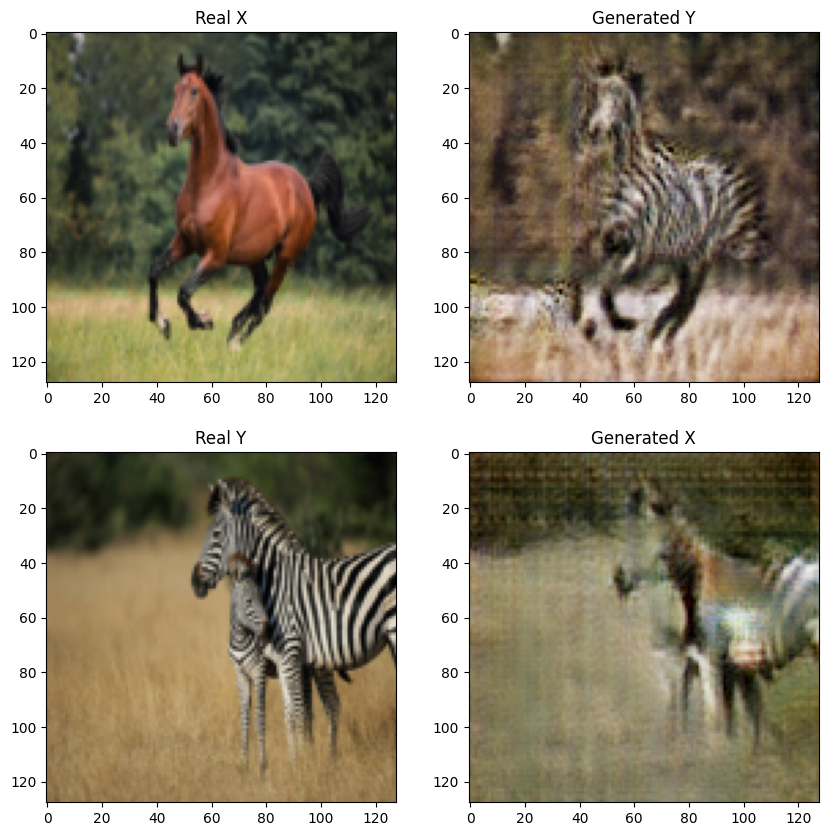

In [ ]:
test(generator_XY, generator_YX, test_loader_X, test_loader_Y)